In [5]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

DIST = 0.9
version_name = "BASELINE_512_Chunk"
FILENAME = f"../../results/{version_name}/{version_name}_no_tol.csv"
OUTPUT = f"../../results/{version_name}/"
os.makedirs(OUTPUT, exist_ok=True)

In [45]:

# -----------------------------------------------#
# --------------------Plots----------------------#
# -----------------------------------------------#


def match_combo(row):
    if row["Filename_Match"] and row["Page_Match"]:
        return "File and Page"
    elif row["Filename_Match"]:
        return "Filename Only"
    elif row["Page_Match"]:
        return "Page Only"
    else:
        return "Neither"
    
def plot_acc_by_cat(df):
    # Extract Query_ID (assumes Result_Id ends with two characters per result)
    df['Query_ID'] = df['Result_Id'].str[:-2]

    # Determine if any of the 5 results per query passed the threshold
    query_match = df.groupby('Query_ID')['Match_Threshold'].any().reset_index()
    query_match.rename(columns={'Match_Threshold': 'Any_Match'}, inplace=True)

    # Get the category for each query (assume all rows with same Query_ID share the same Category)
    query_category = df.groupby('Query_ID')['Category'].first().reset_index()

    # Merge category and match status
    query_summary = pd.merge(query_match, query_category, on='Query_ID')

    # Count how many True/False matches per category
    df_counts = query_summary.groupby(['Category', 'Any_Match']).size().unstack(fill_value=0)

    # Plotting
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(16, 8))

    categories = df_counts.index
    true_counts = df_counts[True] if True in df_counts else [0]*len(categories)
    false_counts = df_counts[False] if False in df_counts else [0]*len(categories)

    plt.bar(categories, false_counts, label='False', color='salmon')
    plt.bar(categories, true_counts, bottom=false_counts, label='True', color='seagreen')

    plt.title("Match Threshold Accuracy by Category (at least one match per query)")
    plt.ylabel("Count of Queries")
    plt.xticks(rotation=45)
    plt.legend(title="Any Match Threshold Met")
    plt.tight_layout()
    plt.show()
    
    
def plot_match_by_diff(df):
    counts = df.groupby(['Difficulty', 'Match_Threshold']).size().unstack(fill_value=0)

    difficulties = counts.index
    false_counts = counts[False] if False in counts else [0]*len(difficulties)
    true_counts = counts[True] if True in counts else [0]*len(difficulties)

    plt.figure(figsize=(8, 6))
    plt.bar(difficulties, false_counts, label='Match_Threshold = False', color='salmon')
    plt.bar(difficulties, true_counts, bottom=false_counts, label='Match_Threshold = True', color='seagreen')

    plt.title("Match Threshold Count by Difficulty")
    plt.ylabel("Count")
    plt.xlabel("Difficulty")
    plt.legend(title="Match_Threshold")
    plt.tight_layout()
    plt.show()
    
def plot_match_file_vs_page(df):
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "File_" + df["Page_Match"].astype(str) + "Page"

    # Plot
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x="Match_Combo", order=df["Match_Combo"].value_counts().index, hue="Match_Combo")

    plt.title("Combined Filename and Page Match For all Results")
    plt.xlabel("Match Combination (Filename_Page)")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    
def plot_threshold_given_page_match(df):
    filtered_df = df[df["Page_Match"]]
    threshold_counts = filtered_df["Match_Threshold"].value_counts().reindex([True, False], fill_value=0)

    plt.figure(figsize=(6, 5))
    plt.bar(threshold_counts.index.map(str), threshold_counts.values, color=['seagreen', 'salmon'])

    plt.title("Match Threshold Counts (Only Where Page Match = True)")
    plt.xlabel("Match_Threshold")
    plt.ylabel("Count")
    # plt.xticks([0, 1], ["True", "False"])
    plt.tight_layout()
    plt.show()
    

def plot_best_result_by_text_match(df):
    df["Combined_Score"] = df["Text_Match_Start_Percent"] + df["Text_Match_End_Percent"]
    df["Result_Tag"] = df["Result_Id"].str[-2:]
    df["Question_Id"] = df["Result_Id"].str[:-2]
    best_results = df.loc[df.groupby("Question_Id")["Combined_Score"].idxmax()]
    result_counts = best_results["Result_Tag"].value_counts().reindex(["R1", "R2", "R3", "R4", "R5"], fill_value=0)

    plt.figure(figsize=(6, 5))
    plt.bar(result_counts.index, result_counts.values, color="cornflowerblue")
    plt.title("Best Result Based on Combined Text Match")
    plt.xlabel("Result (R1, R2, R3, R4, R5)")
    plt.ylabel("Number of Times Best")
    plt.tight_layout()
    plt.show()
    

def plot_matches_heatmap_split(df):
    g = sns.FacetGrid(df, col="Match_Threshold", height=6, aspect=1)
    g.map_dataframe(
        sns.histplot,
        x="Text_Match_End_Percent",
        y="Text_Match_Start_Percent",
        bins=30,
        cmap="coolwarm",
        cbar=True
    )
    g.set_axis_labels("Text Match from End (%)", "Text Match from Start (%)")
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle("Heatmap of Text Match Start vs End (%) by Threshold")
    plt.show()

def plot_accuracy_precision_recall(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Filename_Match'].any()
    accuracy = accuracy_df.mean()
    print("- For Files")

    # Filter by Distance (Random chpice of 0.85, we should think abot this)
    filtered_df = df[df['Distance'] <= DIST]

    # Precision calculation
    # Get matches after filtering
    matches_after_filter = filtered_df.groupby('Query_ID')['Filename_Match'].any()

    # Total queries with results after filtering
    queries_with_results = filtered_df['Query_ID'].unique()

    # Precision = matched queries / total queries with results
    precision = matches_after_filter.sum() / len(queries_with_results)

    # Recall calculation
    # Find all query IDs (with and without results)
    all_queries = df['Query_ID'].unique()

    # Find queries with no results after filtering
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    
    # Recall = matched queries / (matched queries + queries with no results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Queries with results after filtering: " + str(len(queries_with_results)))
    print("Queries with no results after filtering: " + str(len(queries_with_no_results)))
    print("Total number of queries: " + str(len(all_queries)))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall], color=['blue', 'green', 'orange'])
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics (Files)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_accuracy_precision_recall_pages(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Page_Match'].any()
    accuracy = accuracy_df.mean()
    print("- For Pages")
    

    # Filter by Distance (Random chpice of 0.85, we should think abot this)
    filtered_df = df[df['Distance'] <= DIST]

    # Precision calculation
    # Get matches after filtering
    matches_after_filter = filtered_df.groupby('Query_ID')['Page_Match'].any()

    # Total queries with results after filtering
    queries_with_results = filtered_df['Query_ID'].unique()

    # Precision = matched queries / total queries with results
    precision = matches_after_filter.sum() / len(queries_with_results)
    

    # Recall calculation
    # Find all query IDs (with and without results)
    all_queries = df['Query_ID'].unique()

    # Find queries with no results after filtering
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    
    # Recall = matched queries / (matched queries + queries with no results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Queries with results after filtering: " + str(len(queries_with_results)))
    print("Queries with no results after filtering: " + str(len(queries_with_no_results)))
    print("Total number of queries: " + str(len(all_queries)))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall], color=['blue', 'green', 'orange'])
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics  (Pages)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
def plot_accuracy_precision_recall_chunks(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Match_Threshold'].any()
    accuracy = accuracy_df.mean()
    print("- For Chunks")

    # Filter by Distance (Random chpice of 0.85, we should think abot this)
    filtered_df = df[df['Distance'] <= DIST]

    # Precision calculation
    # Get matches after filtering
    matches_after_filter = filtered_df.groupby('Query_ID')['Match_Threshold'].any()

    # Total queries with results after filtering
    queries_with_results = filtered_df['Query_ID'].unique()

    # Precision = matched queries / total queries with results
    precision = matches_after_filter.sum() / len(queries_with_results)

    # Recall calculation
    # Find all query IDs (with and without results)
    all_queries = df['Query_ID'].unique()

    # Find queries with no results after filtering
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    
    # Recall = matched queries / (matched queries + queries with no results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print("Queries with results after filtering: " + str(len(queries_with_results)))
    print("Queries with no results after filtering: " + str(len(queries_with_no_results)))
    print("Total number of queries: " + str(len(all_queries)))

    # Plot
    plt.figure(figsize=(8, 5))
    plt.bar(['Accuracy', 'Precision', 'Recall'], [accuracy, precision, recall], color=['blue', 'green', 'orange'])
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics (Chunks)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

def plot_match_file_vs_page_by_result(df):
    # Extract Result Number (e.g., R1, R2, ..., R5)
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Create combined match string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Create a count dataframe
    count_df = df.groupby(["Match_Combo", "Result_Num"]).size().unstack(fill_value=0)

    # Sort match combos by total count
    count_df = count_df.loc[count_df.sum(axis=1).sort_values(ascending=False).index]

    # Plot
    count_df.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")

    plt.title("Filename and Page Matches by Result Number (Stacked)")
    plt.xlabel("Match Combination (Filename_Page)")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Result Number")
    plt.tight_layout()
    plt.show()


def plot_stacked_matches_by_result3(df):
    # Extract Result Number (e.g., R1, R2, ..., R5)
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Create combined match string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Create a count table: rows = Result_Num, columns = Match_Combo
    count_df = df.groupby(["Result_Num", "Match_Combo"]).size().unstack(fill_value=0)

    # Sort columns by total frequency
    count_df = count_df[count_df.sum().sort_values(ascending=False).index]

    # Plot stacked bars for each Result_Num
    count_df.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="tab20")

    plt.title("Stacked Match Combinations by Result Number")
    plt.xlabel("Result Number")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.legend(title="Match Combination", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
def plot_match_file_vs_page_by_result2(df):
    # Extract Result Number (R1–R5) from Result_Id
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Combine Filename and Page into one string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Initialize FacetGrid with one subplot per result number
    g = sns.FacetGrid(df, col="Result_Num", col_order=["R1", "R2", "R3", "R4", "R5"], 
                      col_wrap=3, height=4, sharex=False, sharey=True)

    # Map countplot onto each subplot
    g.map(sns.countplot, "Match_Combo", order=df["Match_Combo"].value_counts().index)
    
    # Adjust plot aesthetics
    g.set_titles("Result: {col_name}")
    for ax in g.axes.flat:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    g.set_axis_labels("Match Combination (Filename_Page)", "Count")

    plt.tight_layout()
    plt.show()
    
    
def plot_matches_heatmap_split_with_match_type(df):
    # Ensure Match_Combo and Match_Type columns are present
    df["Match_Combo"] = df.apply(match_combo, axis=1)
    size_map = {
        "File and Page": 200,
        "Filename Only": 150,
        "Page Only": 100,
        "Neither": 50
    }
    color_map = {
        "File and Page": "pink",
        "Filename Only": "blue",
        "Page Only": "orange",
        "Neither": "red"
    }
    df["Match_Type"] = df["Match_Combo"].map(lambda x: {
        "File and Page": "File and Page",
        "Filename Only": "Filename Only",
        "Page Only": "Page Only",
        "Neither": "Neither"
    }[x])
    df["Point_Size"] = df["Match_Type"].map(size_map)
    df["Point_Color"] = df["Match_Type"].map(color_map)

    g = sns.FacetGrid(df, col="Match_Threshold", height=6, aspect=1)
    g.map_dataframe(
        sns.scatterplot,
        x="Text_Match_End_Percent",
        y="Text_Match_Start_Percent",
        hue="Match_Type",
        size="Point_Size",
        sizes=(50, 200),
        alpha=0.6,
        palette=color_map,
        legend="full"
    )
    
    g.set_axis_labels("Text Match from End (%)", "Text Match from Start (%)")
    g.figure.subplots_adjust(top=0.85)
    g.figure.suptitle("Match Type Scatter Heatmap by Threshold")
    first_ax = g.axes[0][0]

    # Create custom legend handles
    legend_elements = [
        Line2D(
            [0], [0], marker='o', color='w',
            label=match_type,
            markerfacecolor=color_map[match_type],
            markersize=(size_map[match_type] ** 0.5) * 1.2  # Scaled up for visibility
        )
        for match_type in size_map.keys()
    ]

    # Add legend to the first axis (upper left corner)
    first_ax.legend(
        handles=legend_elements,
        title="Match Type",
        loc='upper left',
        frameon=True,
        borderpad=1
    )
    plt.show()
    
def plot_text_match_info(df):
    # Compute relevant counts
    total_match = df["Match_Threshold"].sum()
    page_match = (df["Match_Threshold"] & df["Page_Match"]).sum()
    page_no_match = (df["Match_Threshold"] & df["Filename_Match"] & ~df["Page_Match"]).sum()
    filename_no_match = (df["Match_Threshold"] & ~df["Filename_Match"]).sum()

    # Plot setup
    fig, ax = plt.subplots(figsize=(8, 6))

    # Bar: Total
    ax.bar('Total', total_match, color='skyblue')

    # Stacked bar: Filename Match (Page Match + No Page Match)
    ax.bar('Filename Match (stacked)', page_match, color='orange', label='Page Match')
    ax.bar('Filename Match (stacked)', page_no_match, bottom=page_match, color='red', label='No Page Match')

    # Bar: Filename No Match
    ax.bar('No Filename Match', filename_no_match, color='green')

    # Legend only for the stacked bars
    ax.legend()

    # Labels and formatting
    ax.set_ylabel("Count")
    ax.set_title("Text Match Types (for all Match_Threshold = True)")
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()
    
    
def plot_filename_histogram(df):
    name_counts = df['Correct_File'].value_counts()
    top_n = 100
    top_names = name_counts.head(top_n)
    plt.figure(figsize=(18, 8))
    top_names.plot(kind='bar')
    plt.title(f"Top {top_n} Most Common Filenames guessed")
    plt.xlabel("Name")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [46]:
df = pd.read_csv(FILENAME, sep=",", encoding="utf-8")

C:\Users\dc91_\AppData\Local\Temp\ipykernel_17304\198377783.py:451: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


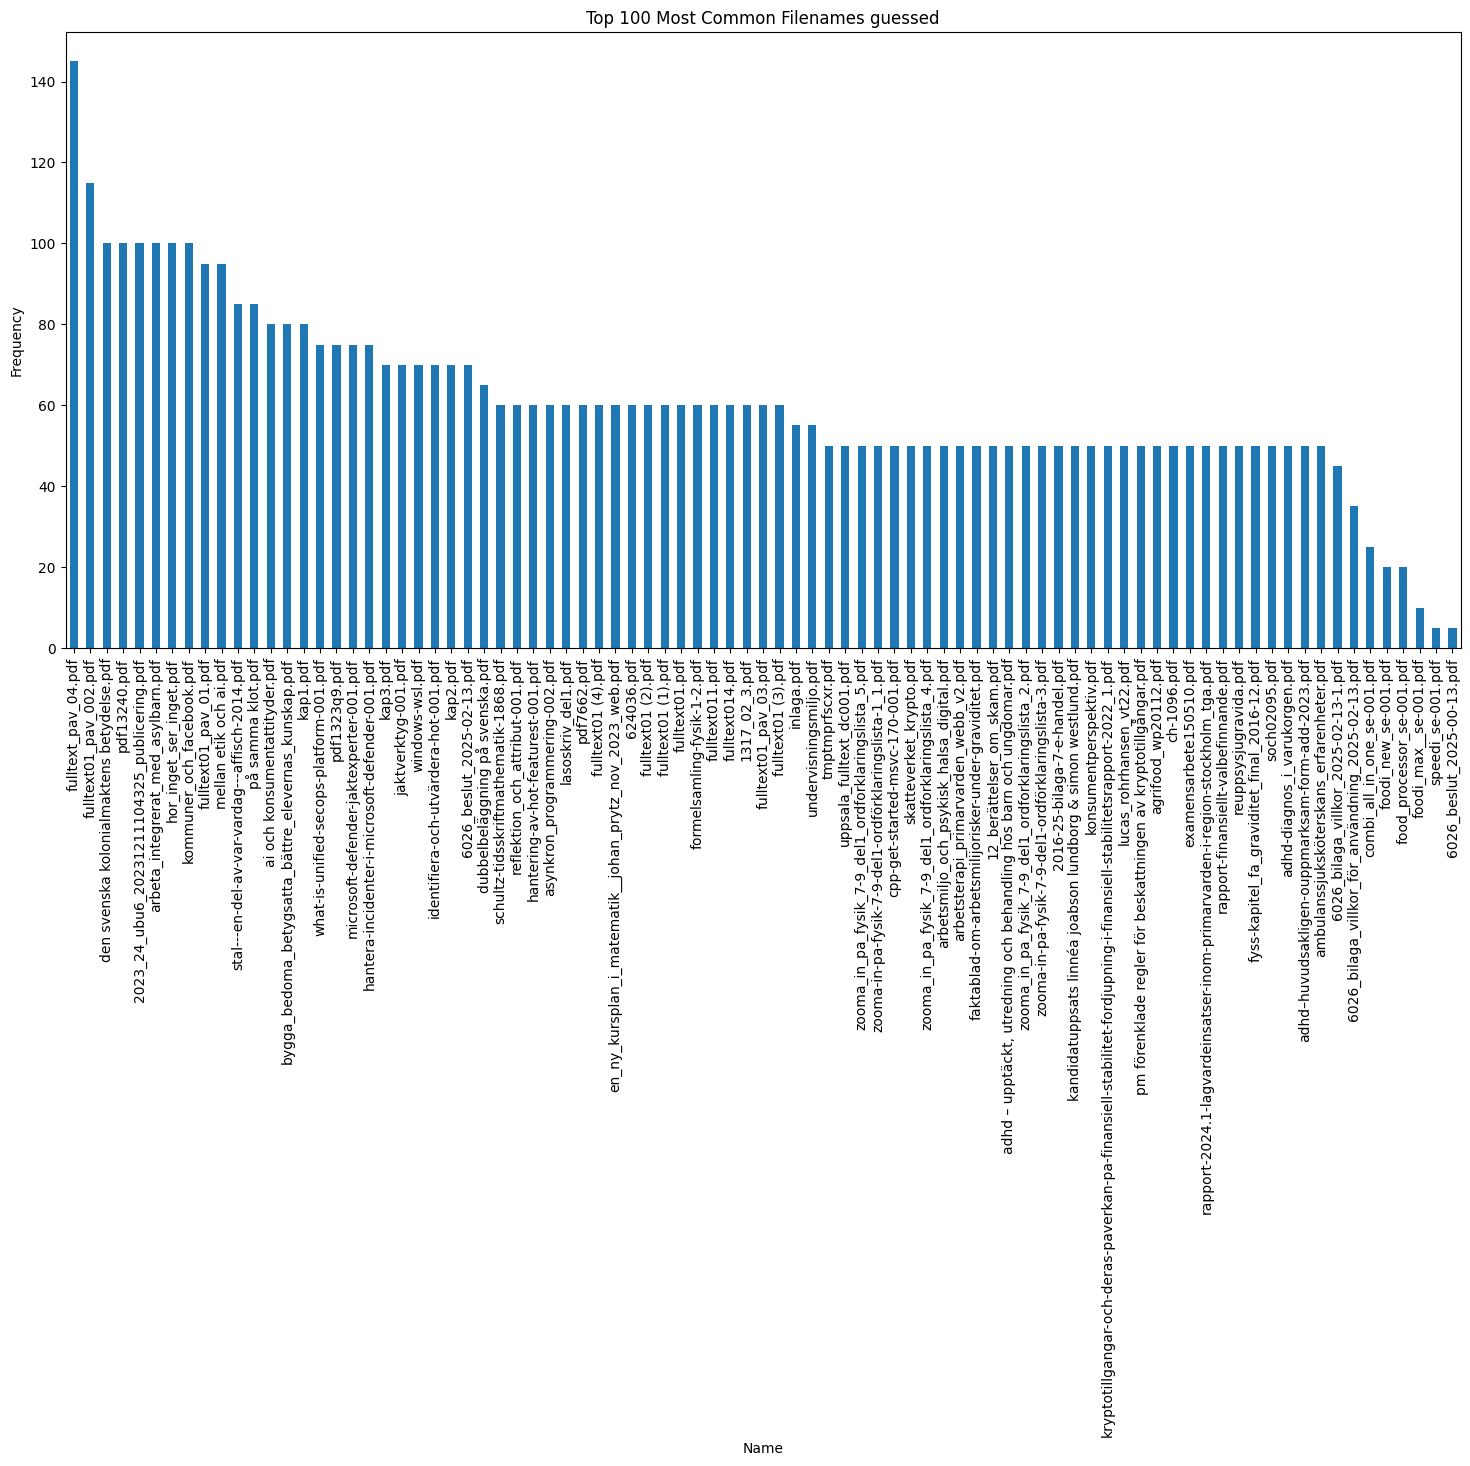

In [47]:
plot_filename_histogram(df)
# plot_match_file_vs_page_by_result2(df)
# plot_match_file_vs_page_by_result(df)
# plot_stacked_matches_by_result3(df)
# plot_match_file_vs_page(df)
# plot_accuracy_precision_recall(df)
# plot_accuracy_precision_recall_pages(df)
# plot_accuracy_precision_recall_chunks(df)


## Here we start involving text match

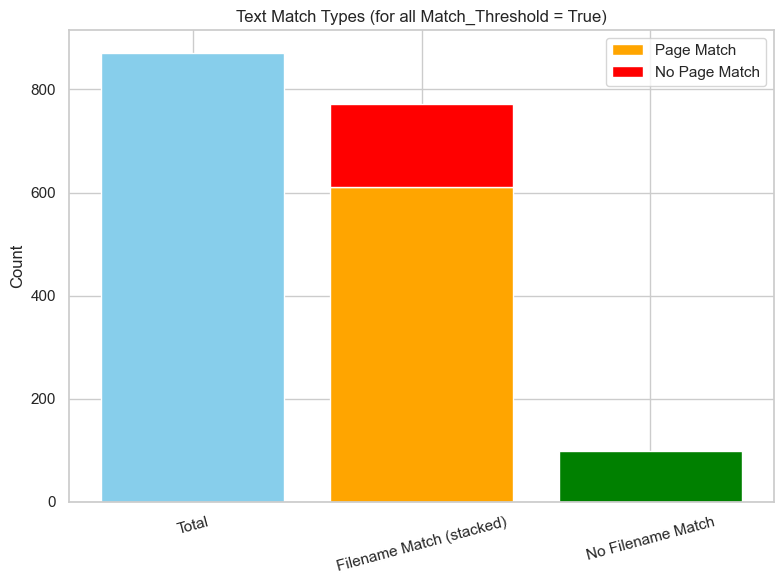

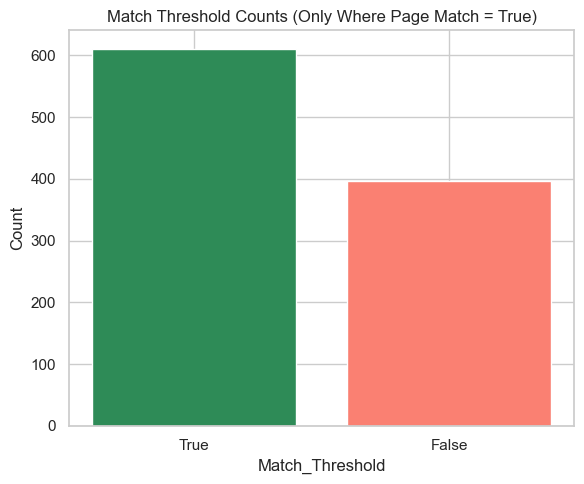

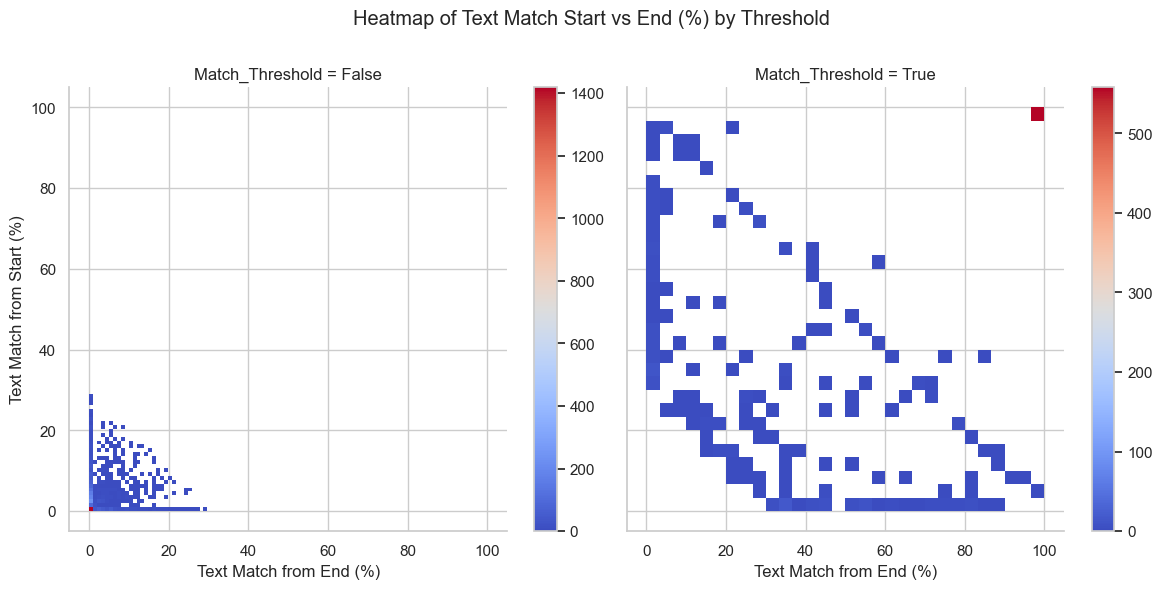

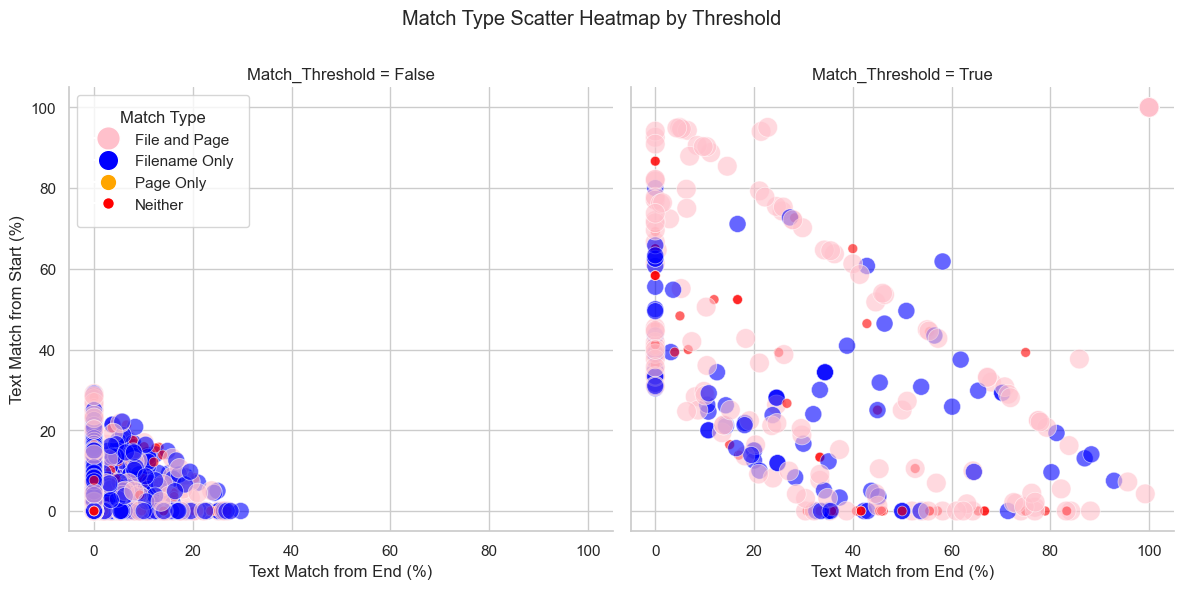

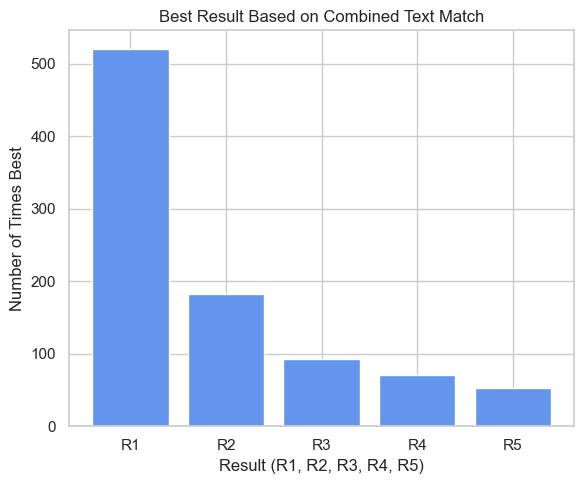

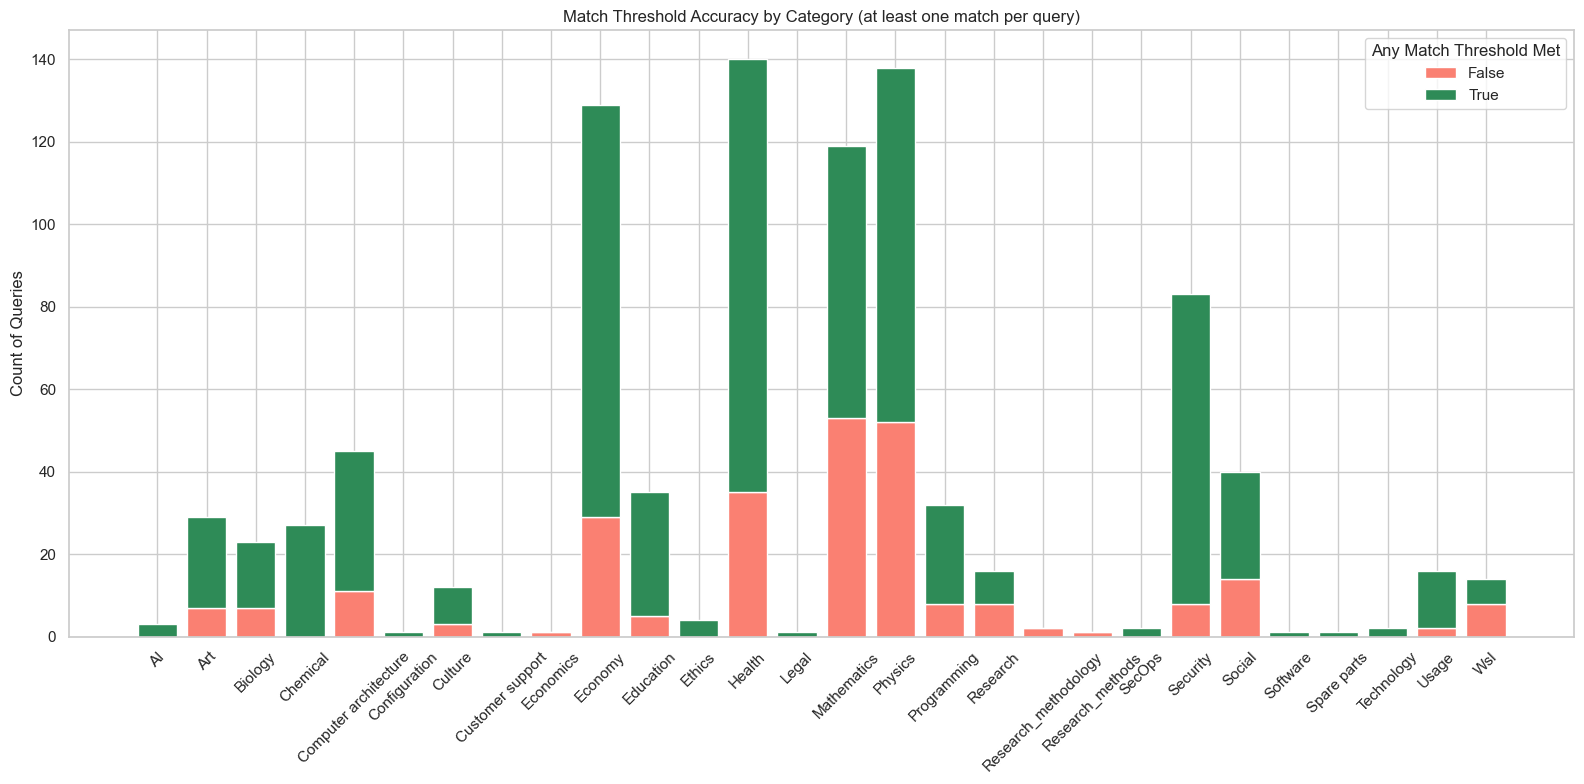

In [210]:
plot_text_match_info(df)
plot_threshold_given_page_match(df)
plot_matches_heatmap_split(df)
plot_matches_heatmap_split_with_match_type(df)
plot_best_result_by_text_match(df)
plot_acc_by_cat(df)